# Mercedes-Benz Greener Manufacturing: Regression Task
## Can you cut the time a Mercedes-Benz spends on the test bench?

This dataset contains an anonymized set of variables, each representing a custom feature in a Mercedes car. For example, a variable could be 4WD, added air suspension, or a head-up display.

The ground truth is labeled `y` and represents the time (in seconds) that the car took to pass testing for each variable.

In [1]:
%load_ext tensorboard
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import os
from copy import deepcopy

In [2]:
KAGGLE_API_KEY_PATH = '/Users/jacksteussie/.kaggle/kaggle.json'     # insert your Kaggle API key path
os.environ["KAGGLE_USERNAME"]='jacksteussie'                        # insert your Kaggle username
os.environ["KAGGLE_KEY"]=json.load(open(KAGGLE_API_KEY_PATH))['key']

In [3]:
DATA_PATH = 'data/mercedez-regression/'
LOG_PATH = 'logs/mercedez-regression/'
MODEL_PATH = 'models/mercedez-regression/'

### Download the Dataset

In [4]:
!kaggle competitions download -c mercedes-benz-greener-manufacturing -p {DATA_PATH}
!unzip -o {DATA_PATH}*.zip -d {DATA_PATH}
!rm {DATA_PATH}*.zip

100%|████████████████████████████████████████| 343k/343k [00:00<00:00, 1.91MB/s]
100%|████████████████████████████████████████| 343k/343k [00:00<00:00, 1.91MB/s]
Archive:  data/mercedez-regression/mercedes-benz-greener-manufacturing.zip
  inflating: data/mercedez-regression/sample_submission.csv.zip  
  inflating: data/mercedez-regression/test.csv.zip  
  inflating: data/mercedez-regression/train.csv.zip  


### Dataset Preprocessing

In [5]:
# Load the data
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')

In [6]:
df_train.head().style

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.810000,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.530000,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.260000,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

In [7]:
# Split the data into X and y
X_train = df_train.drop(['y'], axis=1)
y_train = df_train['y']
X_test = deepcopy(df_test)

In [8]:
from sklearn.preprocessing import OneHotEncoder

# One hot encode the categorical variables
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train[['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']])
X_train_ohe = ohe.transform(X_train[['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']])
X_test_ohe = ohe.transform(X_test[['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']])

In [9]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out())
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out())

In [10]:
X_train_ohe.head()

,X0_a,X0_aa,X0_ab,X0_ac,X0_ad,X0_af,X0_ai,X0_aj,X0_ak,X0_al,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X_train = pd.concat([X_train_ohe, X_train.drop(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], axis=1)], axis=1)
X_test = pd.concat([X_test_ohe, X_test.drop(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], axis=1)], axis=1)

In [12]:
X_train.head().style

In [13]:
# Convert all columns to int64
X_train = X_train.astype(np.int64)
X_test = X_test.astype(np.int64)

In [14]:
X_train.head().style

In [15]:
# Create a validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
# Convert the data to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float64)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float64)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float64)

# Create a dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)

# Batch the data
train_dataset = train_dataset.shuffle(1000).batch(32)
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-31 16:33:52.770576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-31 16:33:52.770685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Model Creation

In [17]:
# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [19]:
# Callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_PATH, histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH + 'model.{epoch:02d}-{val_loss:.2f}.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
)
lr_decay_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

### Model Training

In [20]:
# Train the model
model.fit(
    train_dataset, 
    epochs=50, 
    validation_data=val_dataset, 
    callbacks=[
        tensorboard_callback, 
        # model_checkpoint_callback,
        lr_decay_callback
    ]
)

Epoch 1/50


2023-03-31 16:33:53.219585: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-31 16:33:53.219649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 1s 9ms/step - loss: 3157.7083 - mae: 45.0068 - val_loss: 1496.3075 - val_mae: 31.8655 - lr: 0.0010
Epoch 2/50


2023-03-31 16:33:54.157260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 1s 8ms/step - loss: 665.1677 - mae: 19.7691 - val_loss: 293.0153 - val_mae: 13.8387 - lr: 0.0010
Epoch 3/50
106/106 [==============================] - 1s 9ms/step - loss: 288.6562 - mae: 12.5044 - val_loss: 308.0387 - val_mae: 14.2874 - lr: 0.0010
Epoch 4/50
106/106 [==============================] - 1s 8ms/step - loss: 192.5723 - mae: 10.1408 - val_loss: 223.8118 - val_mae: 12.3555 - lr: 0.0010
Epoch 5/50
106/106 [==============================] - 1s 7ms/step - loss: 275.9409 - mae: 12.0429 - val_loss: 129.7377 - val_mae: 8.9690 - lr: 0.0010
Epoch 6/50
106/106 [==============================] - 1s 8ms/step - loss: 139.4541 - mae: 8.5672 - val_loss: 91.2212 - val_mae: 7.0312 - lr: 0.0010
Epoch 7/50
106/106 [==============================] - 1s 8ms/step - loss: 179.8060 - mae: 9.7435 - val_loss: 107.0066 - val_mae: 8.2665 - lr: 0.0010
Epoch 8/50
106/106 [==============================] - 1s 8ms/step - loss: 137.5907 - mae: 8.4748 - val_loss: 12

### Error Analysis

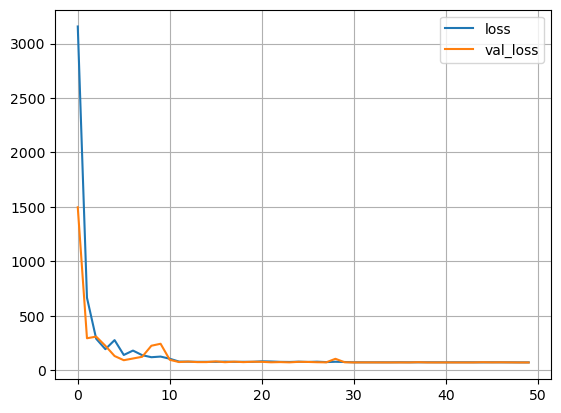

In [21]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid(True)
plt.show()

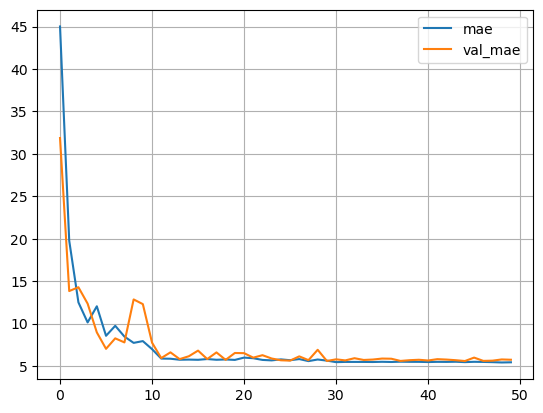

In [22]:
# Plot the mae
plt.plot(model.history.history['mae'], label='mae')
plt.plot(model.history.history['val_mae'], label='val_mae')
plt.legend()
plt.grid(True)
plt.show()

### Predict Test Set and Submit Predictions to Kaggle

In [23]:
# Make predictions
y_pred = model.predict(test_dataset)

2023-03-31 16:34:34.000494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [24]:
# Create a submission file
submission = pd.DataFrame({'ID': df_test['ID'], 'y': y_pred.reshape(-1)})
submission.to_csv(DATA_PATH + 'submission.csv', index=False)

In [25]:
# Submit the predictions
!kaggle competitions submit -c mercedes-benz-greener-manufacturing -f data/mercedez-regression/submission.csv -m "First submission"

100%|██████████████████████████████████████| 59.6k/59.6k [00:01<00:00, 30.6kB/s]
Successfully submitted to Mercedes-Benz Greener Manufacturing